# Analysis of Beijing housing prices

## Content
*Some of the code was taken from the course cds-106@FHGR*

- Imports
- Defining functions
- Running functions

## Imports

In [113]:
# standard libraries
import os
from datetime import datetime
from PIL import Image
from IPython.display import IFrame

# data handling and visualization
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import plotly.express as px
from feature_engine.imputation import MeanMedianImputer
%matplotlib inline

# for Q-Q plots
import scipy.stats as stats

# warnings
import warnings
warnings.filterwarnings("ignore")  # disable warnings in this notebook

## Defining functions

### Dataframe handling

In [114]:
'''
# return encoding of file
def detectEncoding(PATH):
    with open(PATH, 'rb') as rawdata:
        result = chardet.detect(rawdata.read(10000))
    return result
'''

"\n# return encoding of file\ndef detectEncoding(PATH):\n    with open(PATH, 'rb') as rawdata:\n        result = chardet.detect(rawdata.read(10000))\n    return result\n"

In [115]:
# loading the data
def createDataframeFromCSV(PATH, encoding, separator):
    missing_values = ["n/a", "na", "--", ""]  # List of missing value types
    if os.path.exists(PATH) and encoding !="" and separator != "":
        rawData = pd.read_csv(PATH, encoding=encoding, sep=separator, na_values = missing_values)
        return rawData  # return dataframe
    else:
        return "ERROR"  # return error

### Profile report

In [116]:
# create ProfileReport
def createProfileReport(df):
    dt = datetime.now().strftime("%H%M%d%m%Y")  # current dateTime for fileName
    profile = ProfileReport(df, minimal=True)
    fileName = f"DataAnalysis{dt}"
    profile.to_file(output_file=fileName)
    return f"{fileName}.html"

### Data analysis

In [117]:
def getMissingValuesDF(df):
    missingValues = df.isnull().mean().to_dict()
    for column in df.columns:
        if missingValues[column] == 0:
            del missingValues[column]
    missingValues = pd.DataFrame(list(missingValues.items()), columns=['columnName','missingValuePercentage'])
    return missingValues

In [118]:
def getMissingValuesGroupedBy(df, missingValueColumn, groupByColumn):
    df = df.copy()
    df[f'{missingValueColumn}_null'] = np.where(df[missingValueColumn].isnull(),1,0)
    print(f"Percentage of missing values in the {missingValueColumn} variable: {df[f'{missingValueColumn}_null'].mean()}")
    print(f"Percentage of missing values in the {missingValueColumn} variable grouped by: {df.groupby([groupByColumn])[f'{missingValueColumn}_null'].mean()}")

In [119]:
def detectSkewedBoundaries(df, columnName, distance):  # Function to find upper and lower boundaries for skewed distributions
    # Let's calculate the boundaries for skewed distributions
    # The parameter "distance" gives us the option to estimate 1.5 times or 3 times the IQR when defining the boundaries.
    IQR = df[columnName].quantile(0.75) - df[columnName].quantile(0.25)

    lower_boundary = df[columnName].quantile(0.25) - (IQR * distance)
    upper_boundary = df[columnName].quantile(0.75) + (IQR * distance)

    print("upper boundary:", upper_boundary, "| lower boundary:",  lower_boundary)
    #number and percentage of outliers
    print(f'total number of rows: {len(df)}')
    print(f'Having {columnName} changes: {len(df[df[columnName] > upper_boundary])}')
    print(f'% of having {columnName}: {len(df[df[columnName] > upper_boundary]) / len(df)}')

In [120]:
def detectNormalBoundaries(df, columnName):  # Function to find upper and lower boundaries for normally distributed variables.
    # Calculate the boundaries for a Gaussian distribution
    upper_boundary = df[columnName].mean() + 3 * df[columnName].std()
    lower_boundary = df[columnName].mean() - 3 * df[columnName].std()

    print("upper boundary:", upper_boundary, "| lower boundary:",  lower_boundary)
    # number and percentage of outliers
    print(f'total number of rows: {len(df)}')
    print(f'rows with more than {int(upper_boundary)} (right end outliers): {len(df[df[columnName] > upper_boundary])}')
    print(f'% right end outliers: {len(df[df[columnName] > upper_boundary]) / len(df)}')

In [121]:
# detecting and printing information about rare lables
def detectRareLabels(df, columnName):
    data = df[columnName].value_counts()/len(df[columnName])
    print(f"Number of labels in the {columnName} variable: {df[columnName].nunique()}")
    print(f"List of the labels in the {columnName} variable: {df[columnName].unique()}")
    print(f"Value counts percentage for each label:")
    return data

### Visualizations

In [122]:
def generateCorrelationPlot(df, cmap="crest", figsize=(18, 15)):
    plt.figure(figsize=figsize)
    mask = np.triu(np.ones_like(df.corr(), dtype=bool))
    heatmap = sns.heatmap(round(df.corr(), 3), mask=mask, vmin=-1, vmax=1, annot=True, cmap=cmap, linewidths=.5)
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)
    rcParams.update({'figure.autolayout': True})
    plt.show()

In [123]:
# Function to create a histogram, a Q-Q plot and a boxplot
def generateDiagnosticPlots(df, columnNames):
    fig=plt.figure(figsize=(15, 4*len(columnNames)))
    i=1
    for j in range(len(columnNames)):
        # histogram
        plt.subplot(len(columnNames), 3, i)
        sns.histplot(df[columnNames[j]], bins=30)
        plt.title(f"Histogram: {columnNames[j]}")
        i+=1
        # Q-Q plot
        plt.subplot(len(columnNames), 3, i)
        stats.probplot(df[columnNames[j]], dist="norm", plot=plt)
        plt.ylabel(f"RM quantiles: {columnNames[j]}")
        i+=1
        # boxplot
        plt.subplot(len(columnNames), 3, i)
        sns.boxplot(y=df[columnNames[j]])
        plt.title(f"Boxplot: {columnNames[j]}")
        i+=1
    return fig

In [124]:
def generateHistogram(df, columnName, bins=30):
    # histogram
    fig=plt.figure(figsize=(15, 5))
    sns.histplot(df[columnName], bins=bins)
    plt.title(f"Histogram | {columnName}")
    
    return fig

In [125]:
def generateQQPlot(df, columnName):
    # Q-Q plot
    fig=plt.figure(figsize=(15, 5))
    stats.probplot(df[columnName], dist="norm", plot=plt)
    plt.ylabel(f"RM quantiles | {columnName}")

    return fig

In [126]:
def generateBoxplot(df, columnName):
    # boxplot
    fig=plt.figure(figsize=(15, 5))
    sns.boxplot(y=df[columnName])
    plt.title(f"Boxplot | {columnName}")

    return fig

In [127]:
def generateBarChart(x, y, ax=None, **plt_kwargs):
    if ax is None:
        ax = plt.gca()
    ax.bar(x, y, **plt_kwargs)
    for i in range(len(y)):
        ax.text(i-i/100, y[i]+y[i]/100, round(y[i], 4))
    return(ax)

In [128]:
# barchart for rare lable visualization
def visualizeRareLabels(df, columnName, ax=None, **plt_kwargs):
    if ax is None:
        ax = plt.gca()
    data = df[columnName].value_counts()/len(df[columnName])
    idx = np.asarray([i for i in range(len(data))])
    ax.bar(data.index, data.tolist(), color ='turquoise', width = 0.4)  # creating the bar plot
    ax.set_xlabel("Label")
    ax.set_ylabel("Ratio")
    ax.set_xticks(idx)
    ax.set_title(columnName)
    return ax

### Dataframe manipulation

In [129]:
def splitDateColumn(df, columnName):
    df[f'{columnName}Year'] = df[columnName].dt.year
    df[f'{columnName}Month'] = df[columnName].dt.month
    df[f'{columnName}Day'] = df[columnName].dt.day
    df[f'{columnName}_week_of_year'] = df[columnName].dt.week
    df[f'{columnName}_day_of_week'] = df[columnName].dt.dayofweek
    return df

In [130]:
# delete empty rows of a dataframe
def deleteEmptyRows(df):
    df.replace('', np.nan, inplace=True)
    df.dropna(inplace=True)
    return df

## Running functions

### Load data

In [131]:
rawData = createDataframeFromCSV(PATH="../beijing.csv", encoding="iso-8859-1", separator=",")
gbk_rawData = createDataframeFromCSV(PATH="../beijing.csv", encoding="gbk", separator=",")  # gbk encoding for chinese characters
rawData.head()

,url,id,Lng,Lat,Cid,tradeTime,DOM,followers,totalPrice,price,...,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
0,https://bj.lianjia.com/chengjiao/101084782030....,101084782030,116.475489,40.019520,1111027376244,2016-08-09,1464.0,106,415.0,31680,...,1.0,2005,3,6,0.217,1.0,0.0,1.0,7,56021.0
1,https://bj.lianjia.com/chengjiao/101086012217....,101086012217,116.453917,39.881534,1111027381879,2016-07-28,903.0,126,575.0,43436,...,1.0,2004,4,6,0.667,1.0,1.0,0.0,7,71539.0
2,https://bj.lianjia.com/chengjiao/101086041636....,101086041636,116.561978,39.877145,1111040862969,2016-12-11,1271.0,48,1030.0,52021,...,4.0,2005,3,6,0.500,1.0,0.0,0.0,7,48160.0
3,https://bj.lianjia.com/chengjiao/101086406841....,101086406841,116.438010,40.076114,1111043185817,2016-09-30,965.0,138,297.5,22202,...,1.0,2008,1,6,0.273,1.0,0.0,0.0,6,51238.0
4,https://bj.lianjia.com/chengjiao/101086920653....,101086920653,116.428392,39.886229,1111027381174,2016-08-28,927.0,286,392.0,48396,...,4.0,1960,2,2,0.333,0.0,1.0,1.0,1,62588.0


In [132]:
data = rawData.copy()  # create copy of originial dataframe

### Profile report

In [133]:
#createProfileReport(data)  # create ProfileReport before analysis

### Data informations and dataframe customizations

In [134]:
data.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318851 entries, 0 to 318850
Columns: 26 entries, url to communityAverage
dtypes: float64(11), int64(7), object(8)
memory usage: 63.2+ MB


In [135]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318851 entries, 0 to 318850
Data columns (total 26 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   url                  318851 non-null  object 
 1   id                   318851 non-null  object 
 2   Lng                  318851 non-null  float64
 3   Lat                  318851 non-null  float64
 4   Cid                  318851 non-null  int64  
 5   tradeTime            318851 non-null  object 
 6   DOM                  160874 non-null  float64
 7   followers            318851 non-null  int64  
 8   totalPrice           318851 non-null  float64
 9   price                318851 non-null  int64  
 10  square               318851 non-null  float64
 11  livingRoom           318851 non-null  object 
 12  drawingRoom          318851 non-null  object 
 13  kitchen              318851 non-null  int64  
 14  bathRoom             318851 non-null  object 
 15  floor            

#### Chinese characters in column floor and constructionTime

In [141]:
gbk_rawData['constructionTime'].value_counts()

2004    21145
2003    19409
未知      19283
2005    18924
2006    14854
        ...  
1934        2
1944        2
1906        1
1933        1
1914        1
Name: constructionTime, Length: 74, dtype: int64

In [ ]:
gbk_rawData.floor.head()

0    高 26
1    高 22
2     中 4
3    底 21
4     中 6
Name: floor, dtype: object

We have to split the two informations in column floor

In [ ]:
gbk_rawData['floorType'] = gbk_rawData['floor'].str.replace('\d+', '')  # extract chinese characters (everything but numbers)

In [ ]:
gbk_rawData["floor"] = gbk_rawData.floor.str.extract('(\d+)')  # extract only numbers

In [ ]:
gbk_rawData[["floor", "floorType"]]

,floor,floorType
0,26,高
1,22,高
2,4,中
3,21,底
4,6,中
...,...,...
318846,5,中
318847,24,中
318848,7,中
318849,5,中


In [ ]:
gbk_rawData["floorType"].value_counts()

中       119832
高        70094
低        64136
顶        37406
底        26080
未知        1271
钢混结构        17
混合结构        15
Name: floorType, dtype: int64

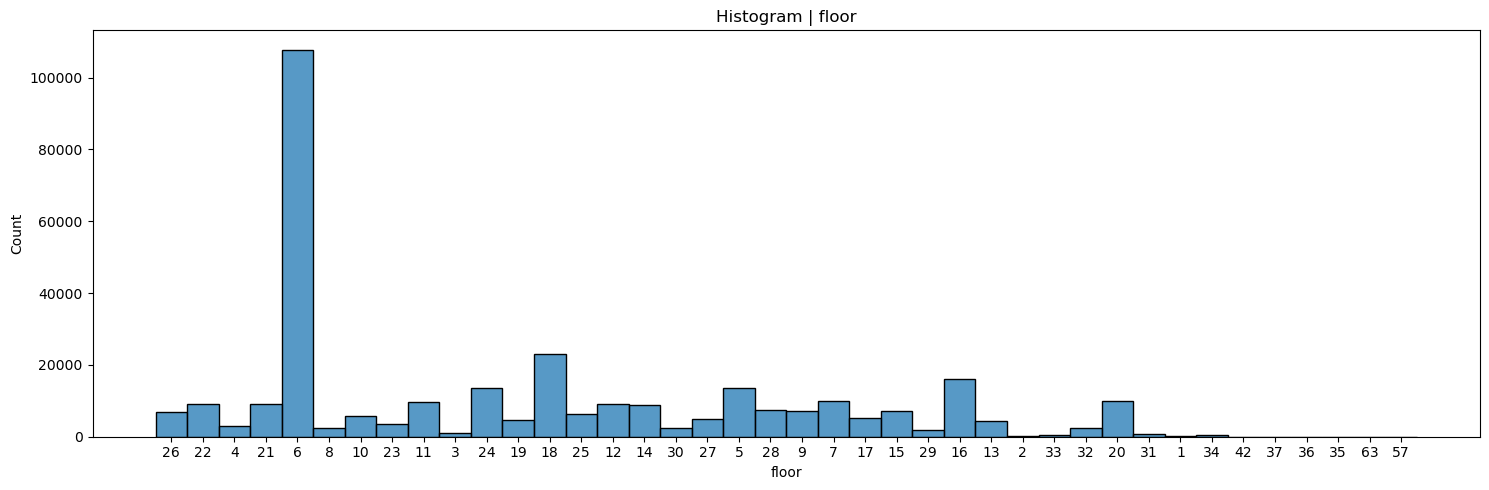

In [ ]:
generateHistogram(df=gbk_rawData, columnName="floor", bins=50);

In [ ]:
chineseChar = gbk_rawData.floorType.unique()
chineseChar

array(['高 ', '中 ', '底 ', '低 ', '顶 ', '未知 ', '钢混结构', '混合结构'], dtype=object)

In [ ]:
# create dict with translations
translationDict = {}
translationDict["高 "] = "High"
translationDict["中 "] = "Medium"
translationDict["底 "] = "Bottom"
translationDict["低 "] = "Low"
translationDict["顶 "] = "Top"
translationDict["未知 "] = "Unknown"
translationDict["钢混结构"] = "Steel-composite construction"
translationDict["混合结构"] = "Hybrid structure"
translationDict

{'高 ': 'High',
 '中 ': 'Medium',
 '底 ': 'Bottom',
 '低 ': 'Low',
 '顶 ': 'Top',
 '未知 ': 'Unknown',
 '钢混结构': 'Steel-composite construction',
 '混合结构': 'Hybrid structure'}

In [ ]:
for index_label, row_series in gbk_rawData.iterrows():
    # For each row update the 'floorType' value to it's translation
    gbk_rawData.at[index_label , 'floorType'] = translationDict[row_series['floorType']]
gbk_rawData[["floor", "floorType"]].head()

,floor,floorType
0,26,High
1,22,High
2,4,Medium
3,21,Bottom
4,6,Medium


#### Add data to original df

In [ ]:
data.rename(columns = {'floor':'floor_old'}, inplace = True)  # rename current floor column
data.insert(0, "floor", gbk_rawData["floor"])  # add new floor column to df
data.insert(0, "floorType", gbk_rawData["floorType"])  # add new floorType column to df
data[["floor", "floorType"]]

,floor,floorType
0,26,High
1,22,High
2,4,Medium
3,21,Bottom
4,6,Medium
...,...,...
318846,5,Medium
318847,24,Medium
318848,7,Medium
318849,5,Medium


#### Convert dtypes

Let pandas detect dtypes automatically

In [ ]:
dfn = data.convert_dtypes()
dfn.dtypes

floorType               string
floor                   string
url                     string
id                      object
Lng                    Float64
Lat                    Float64
Cid                      Int64
tradeTime               string
DOM                      Int64
followers                Int64
totalPrice             Float64
price                    Int64
square                 Float64
livingRoom              object
drawingRoom             object
kitchen                  Int64
bathRoom                object
floor_old               string
buildingType           Float64
constructionTime        string
renovationCondition      Int64
buildingStructure        Int64
ladderRatio            Float64
elevator                 Int64
fiveYearsProperty        Int64
subway                   Int64
district                 Int64
communityAverage         Int64
dtype: object

##### Convert dtypes manually
errors:
- If ‘raise’, then invalid parsing will raise an exception.
- If ‘coerce’, then invalid parsing will be set as NaN.
- If ‘ignore’, then invalid parsing will return the input.

In [ ]:
data["tradeTime"] = pd.to_datetime(data["tradeTime"], format="%Y-%m-%d")  # Convert date to correct dtype
data["id"] = pd.to_numeric(data["id"], errors='coerce')
data["livingRoom"] = pd.to_numeric(data["livingRoom"], errors='coerce')
data["drawingRoom"] = pd.to_numeric(data["drawingRoom"], errors='coerce')
data["bathRoom"] = pd.to_numeric(data["bathRoom"], errors='coerce')
data["constructionTime"] = pd.to_numeric(data["constructionTime"], errors='coerce')
#data["constructionTime"] = pd.to_datetime(data["constructionTime"], format="%Y")
data["floor"] = pd.to_numeric(data["floor"], errors='coerce')
data["floorType"] = data["floorType"].astype("string")

In [ ]:
data.dtypes

floorType                      string
floor                         float64
url                            object
id                            float64
Lng                           float64
Lat                           float64
Cid                             int64
tradeTime              datetime64[ns]
DOM                           float64
followers                       int64
totalPrice                    float64
price                           int64
square                        float64
livingRoom                    float64
drawingRoom                   float64
kitchen                         int64
bathRoom                      float64
floor_old                      object
buildingType                  float64
constructionTime              float64
renovationCondition             int64
buildingStructure               int64
ladderRatio                   float64
elevator                      float64
fiveYearsProperty             float64
subway                        float64
district    

#### Split date column into multiple columns

In [ ]:
data = splitDateColumn(df=data, columnName="tradeTime")

#### First investigation for empty values

In [ ]:
data.isna().sum()

floorType                      0
floor                         32
url                            0
id                        226635
Lng                            0
Lat                            0
Cid                            0
tradeTime                      0
DOM                       157977
followers                      0
totalPrice                     0
price                          0
square                         0
livingRoom                    32
drawingRoom                   32
kitchen                        0
bathRoom                       2
floor_old                      0
buildingType                2021
constructionTime           19283
renovationCondition            0
buildingStructure              0
ladderRatio                    0
elevator                      32
fiveYearsProperty             32
subway                        32
district                       0
communityAverage             463
tradeTimeYear                  0
tradeTimeMonth                 0
tradeTimeD

### Correlations

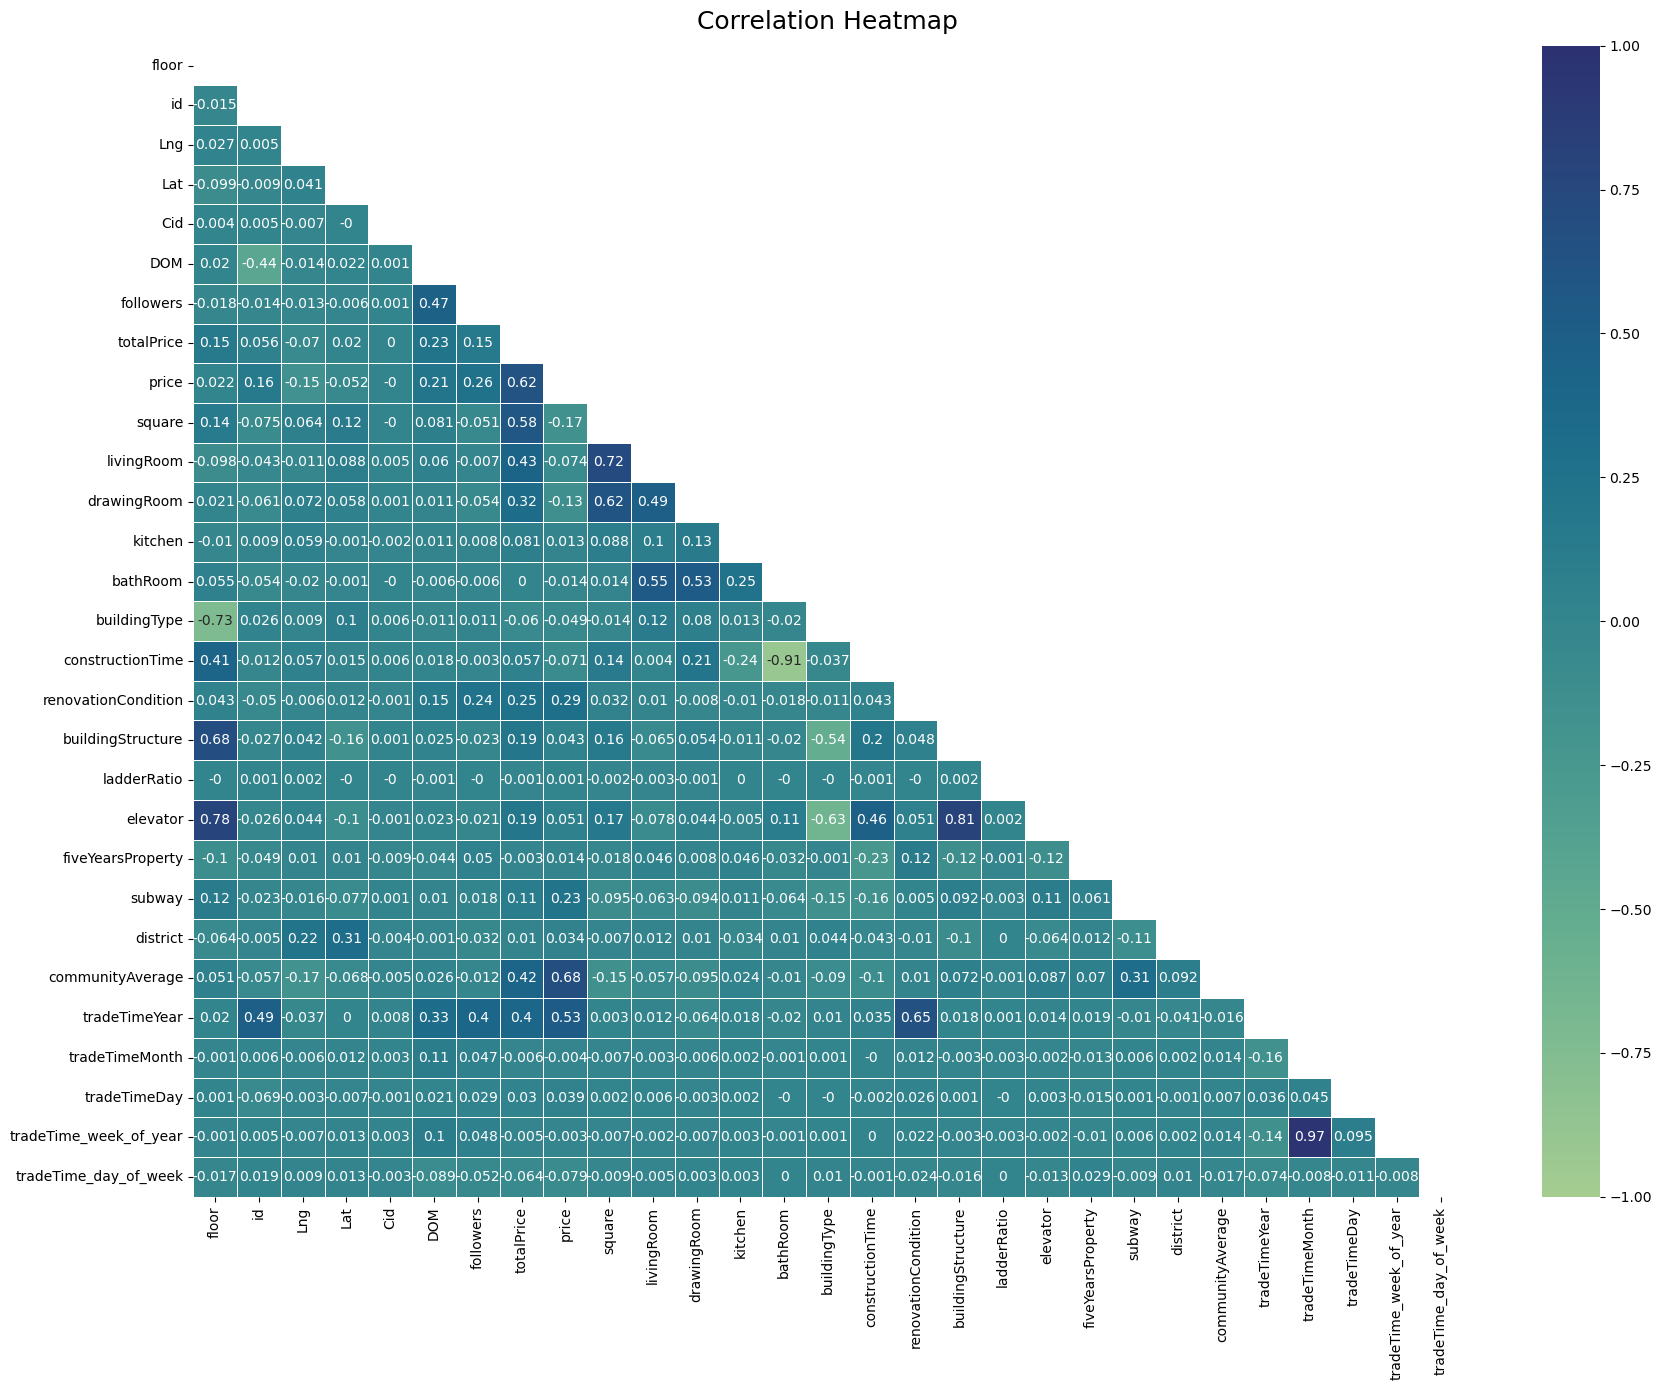

In [ ]:
generateCorrelationPlot(df=data, figsize=(18,14))

### Drop unnecessary columns

In [ ]:
data.drop(['DOM'], axis=1, inplace=True)  # Too many missing values -> 50%
data.drop(['id', 'url'], axis=1, inplace=True)  # IDs and URLs are not needed

### Missing values

In [ ]:
missingValues = getMissingValuesDF(data)
missingValues

,columnName,missingValuePercentage
0,floor,0.000100
1,livingRoom,0.000100
2,drawingRoom,0.000100
3,bathRoom,0.000006
4,buildingType,0.006338
5,constructionTime,0.060477
6,elevator,0.000100
7,fiveYearsProperty,0.000100
8,subway,0.000100
9,communityAverage,0.001452


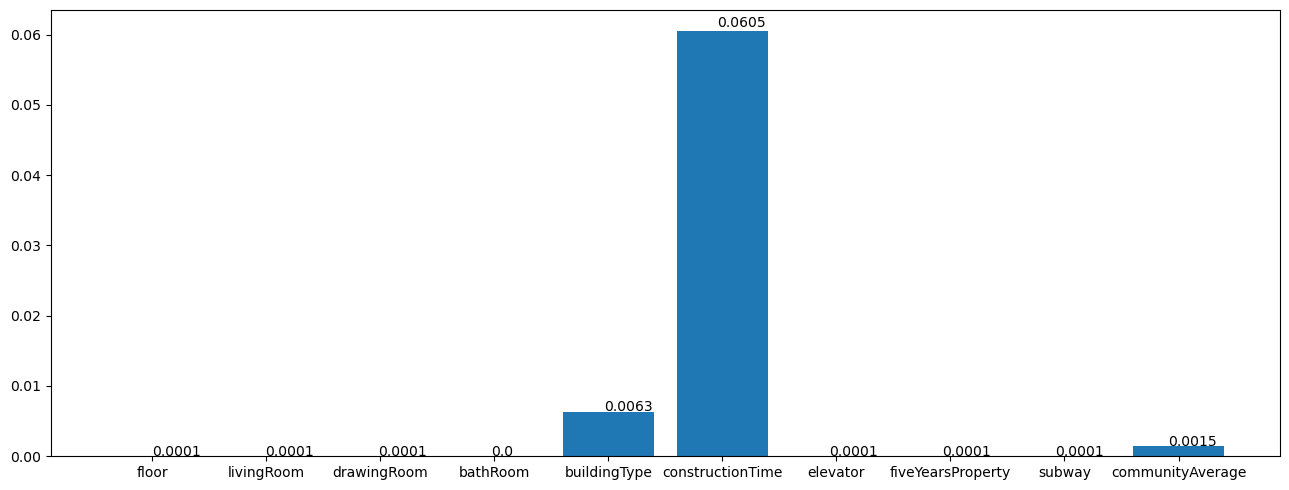

In [ ]:
fig= plt.figure(figsize=(13,5))
generateBarChart(x=missingValues['columnName'], y=missingValues['missingValuePercentage'])
fig.tight_layout()
fig.show()

In [ ]:
missingValueColumns = missingValues['columnName'].to_list()
missingValueColumns

['floor',
 'livingRoom',
 'drawingRoom',
 'bathRoom',
 'buildingType',
 'constructionTime',
 'elevator',
 'fiveYearsProperty',
 'subway',
 'communityAverage']

#### Check if missing values are missing at random

In [ ]:
for missingValueColumn in missingValueColumns:
    print('-------------------------------------------------------------------------------------------------------------')
    getMissingValuesGroupedBy(df=data, missingValueColumn = missingValueColumn, groupByColumn = 'district')

-------------------------------------------------------------------------------------------------------------
Percentage of missing values in the floor variable: 0.00010036035640471568
Percentage of missing values in the floor variable grouped by: district
1     0.000000
2     0.000170
3     0.000000
4     0.000065
5     0.000000
6     0.000026
7     0.000009
8     0.000079
9     0.000000
10    0.000000
11    0.000000
12    0.012324
13    0.000000
Name: floor_null, dtype: float64
-------------------------------------------------------------------------------------------------------------
Percentage of missing values in the livingRoom variable: 0.00010036035640471568
Percentage of missing values in the livingRoom variable grouped by: district
1     0.000000
2     0.000170
3     0.000000
4     0.000065
5     0.000000
6     0.000026
7     0.000009
8     0.000079
9     0.000000
10    0.000000
11    0.000000
12    0.012324
13    0.000000
Name: livingRoom_null, dtype: float64
---------------

---

>We should only use variables/columns with less than 5% missing values according to Soldedad Galli (2017).

>We have one variable with 6% missing values which we should not drop and try to fill up.

In [ ]:
print("Columns with less than 5% missing Values:", [column for column in missingValueColumns if data[column].isnull().mean() < 0.05])
print("-------------------------------------------------------------------------------------")
print("Columns with more than 5% missing Values:", [column for column in missingValueColumns if data[column].isnull().mean() > 0.05])

Columns with less than 5% missing Values: ['floor', 'livingRoom', 'drawingRoom', 'bathRoom', 'buildingType', 'elevator', 'fiveYearsProperty', 'subway', 'communityAverage']
-------------------------------------------------------------------------------------
Columns with more than 5% missing Values: ['constructionTime']


In [ ]:
dataWithNA = data[data.isnull().any(axis=1)]  # rows with na values
dataWithNA = dataWithNA[missingValueColumns]  # select only columns with missing values
dataWithNA.info()  # shows total rows with na values and how they are distributed

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21150 entries, 10 to 318850
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   floor              21118 non-null  float64
 1   livingRoom         21118 non-null  float64
 2   drawingRoom        21118 non-null  float64
 3   bathRoom           21148 non-null  float64
 4   buildingType       19129 non-null  float64
 5   constructionTime   1867 non-null   float64
 6   elevator           21118 non-null  float64
 7   fiveYearsProperty  21118 non-null  float64
 8   subway             21118 non-null  float64
 9   communityAverage   20687 non-null  float64
dtypes: float64(10)
memory usage: 1.8 MB


### Diagnostic plots

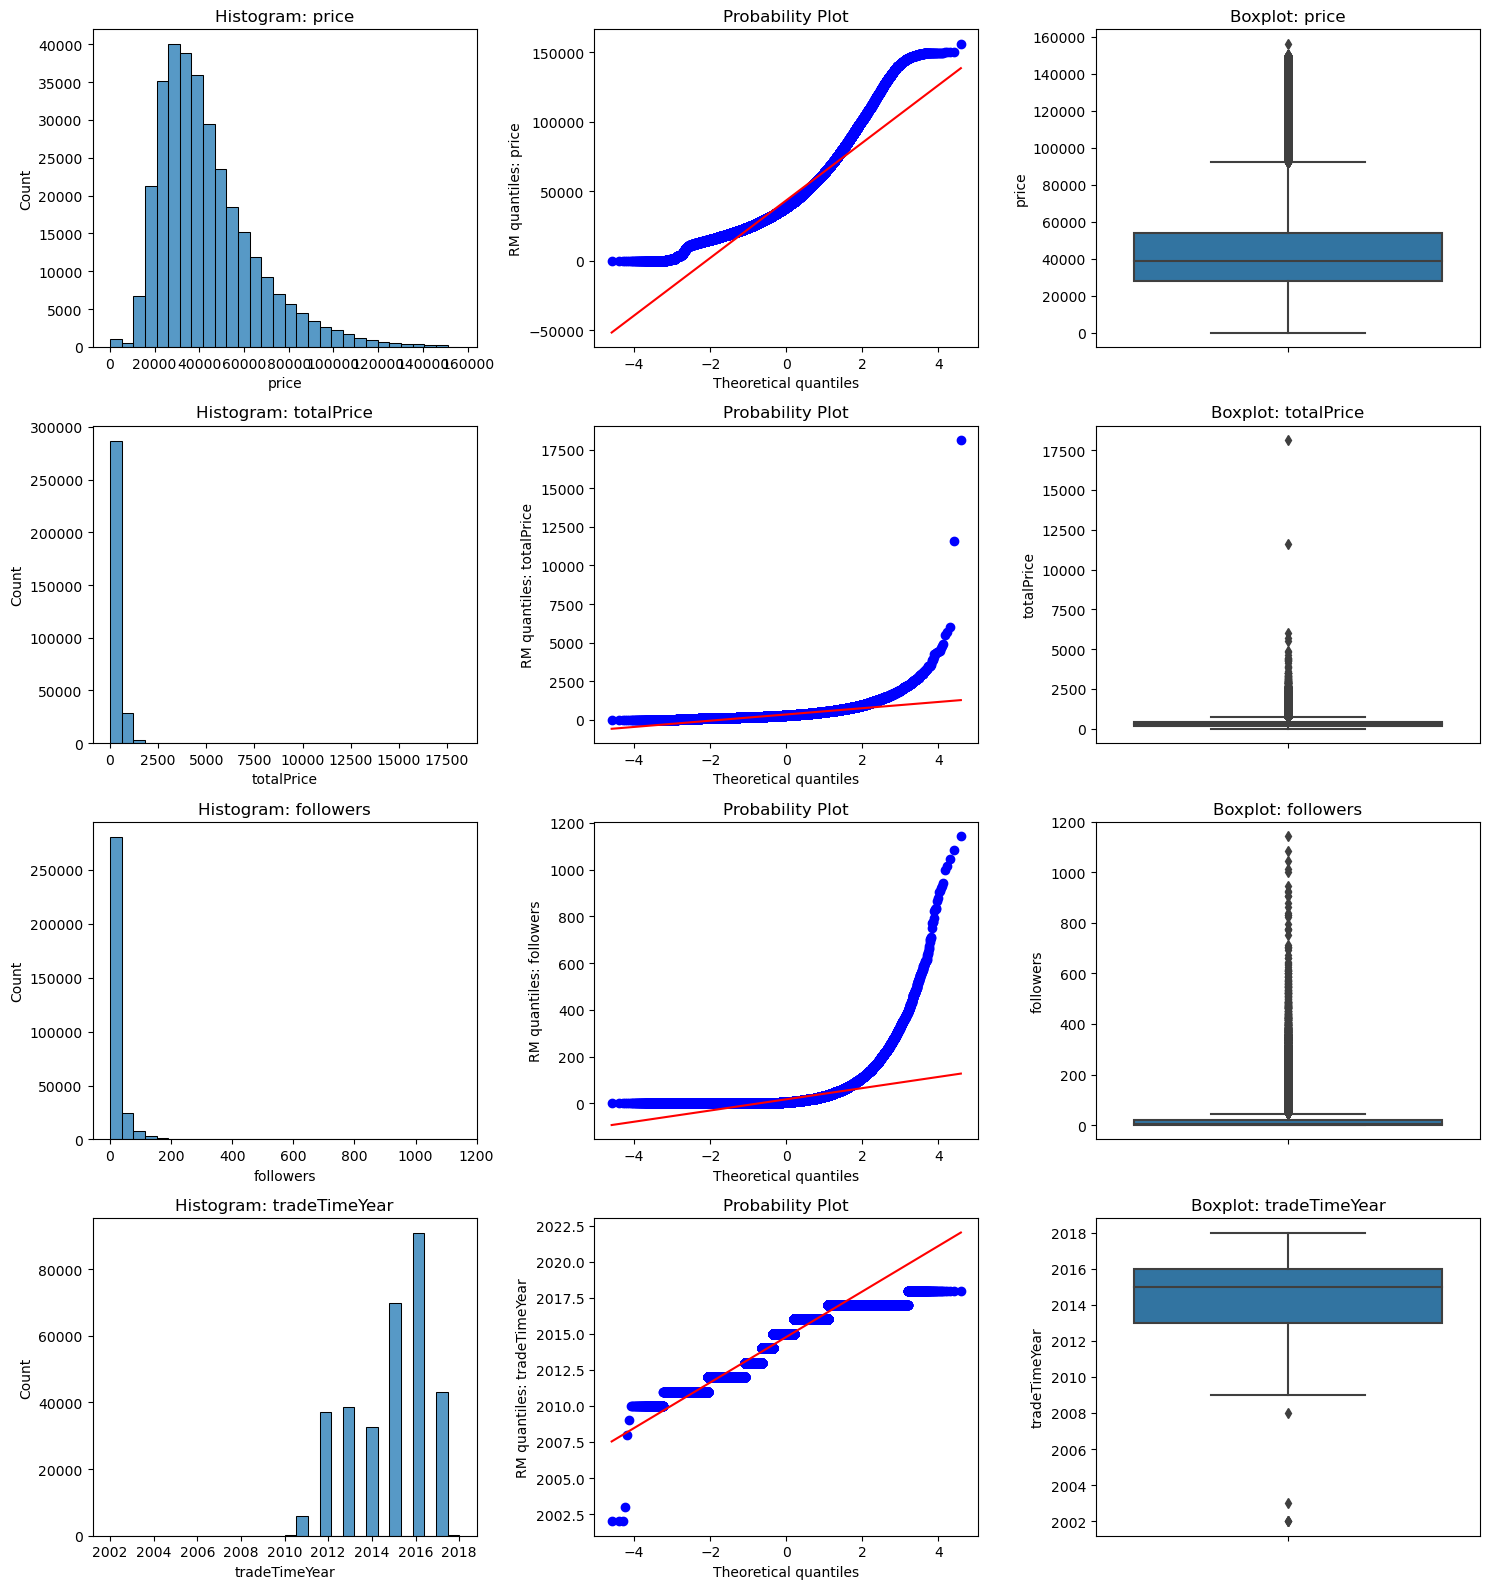

In [ ]:
fig = generateDiagnosticPlots(data, columnNames=["price", "totalPrice", "followers", "tradeTimeYear"])
fig.tight_layout()
fig.show()

### Outliers

In [ ]:
detectSkewedBoundaries(data, 'price', 1.5)

upper boundary: 92473.75 | lower boundary: -10604.25
total number of rows: 318851
Having price changes: 11752
% of having price: 0.036857340889631836


In [ ]:
detectNormalBoundaries(data, 'price')

upper boundary: 108657.50899015594 | lower boundary: -21596.636231406563
total number of rows: 318851
rows with more than 108657 (right end outliers): 4733
% right end outliers: 0.014843923964484978


### Rare labels

In [ ]:
# print all columns
data.columns

Index(['floorType', 'floor', 'Lng', 'Lat', 'Cid', 'tradeTime', 'followers',
       'totalPrice', 'price', 'square', 'livingRoom', 'drawingRoom', 'kitchen',
       'bathRoom', 'floor_old', 'buildingType', 'constructionTime',
       'renovationCondition', 'buildingStructure', 'ladderRatio', 'elevator',
       'fiveYearsProperty', 'subway', 'district', 'communityAverage',
       'tradeTimeYear', 'tradeTimeMonth', 'tradeTimeDay',
       'tradeTime_week_of_year', 'tradeTime_day_of_week'],
      dtype='object')

In [ ]:
detectRareLabels(data, columnName="renovationCondition")

Number of labels in the renovationCondition variable: 5
List of the labels in the renovationCondition variable: [3 4 1 2 0]
Value counts percentage for each label:


1    0.372418
4    0.368316
3    0.242279
2    0.016904
0    0.000082
Name: renovationCondition, dtype: float64

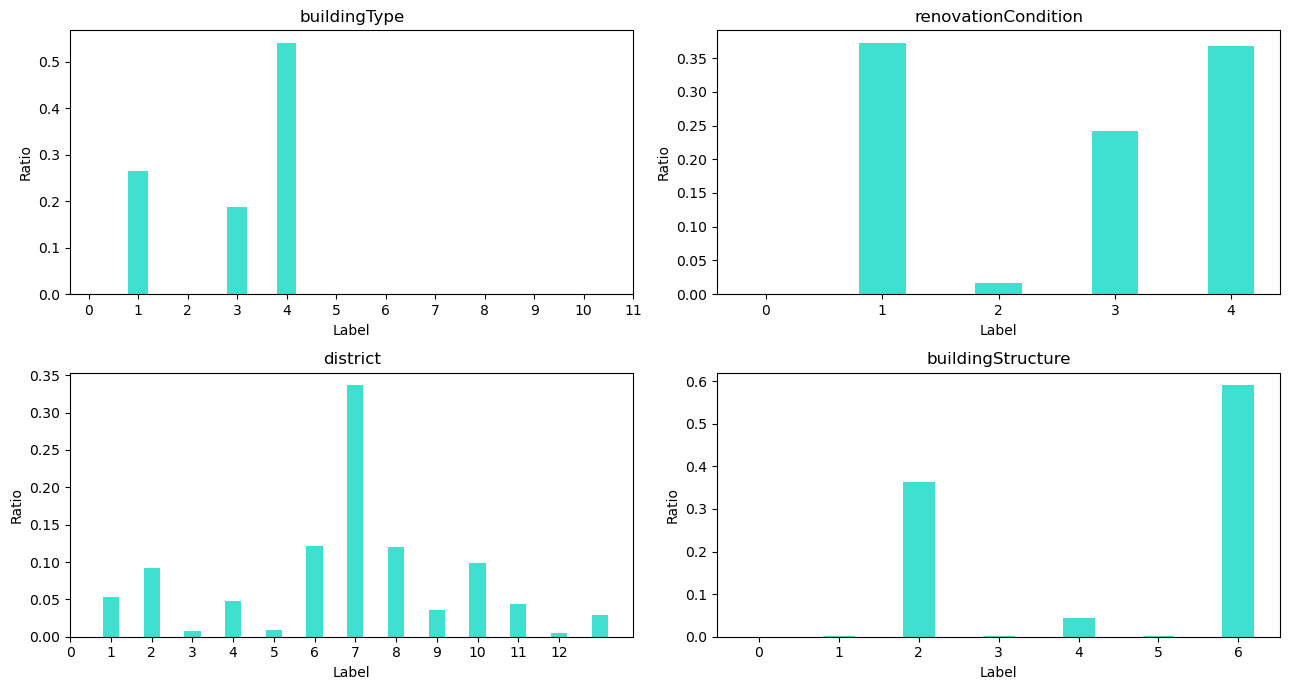

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(13,7))
visualizeRareLabels(data, columnName='buildingType', ax=ax[0][0])
visualizeRareLabels(data, columnName='renovationCondition', ax=ax[0][1])
visualizeRareLabels(data, columnName='district', ax=ax[1][0])
visualizeRareLabels(data, columnName='buildingStructure', ax=ax[1][1])
fig.tight_layout()
plt.show();

### Map visualization

In [ ]:
'''beijingMap = Image.open(r"content/Better_Crop.png")
beijingScatter = px.scatter(x=data["Lng"], y=data["Lat"], color=data["price"], width=808.5, height=1002.5, labels={'x': '', 'y': ''}, color_continuous_scale=px.colors.sequential.Plasma)
beijingScatter.update_xaxes(range=[116.06, 116.74], side="top", visible=False)
beijingScatter.update_yaxes(range=[39.62, 40.26], visible=False)
beijingScatter.update_layout(title={
    'text': f"Beijing",
    'x': 0.5,
    'y': 0.97,
    'xanchor': 'center',
    'yanchor': 'top',
    'font_size': 24
})

beijingScatter.add_layout_image(  
    # background
    dict(
        x=0,
        sizex=1,
        y=1,
        sizey=1,
        xanchor="left",
        yanchor="top",
        xref="paper",
        yref="paper",
        opacity=0.95,
        layer="below",
        sizing="stretch",
        source=beijingMap)
)

beijingScatter.layout.xaxis.fixedrange = True
beijingScatter.layout.yaxis.fixedrange = True

beijingScatter.show()'''

'beijingMap = Image.open(r"content/Better_Crop.png")\nbeijingScatter = px.scatter(x=data["Lng"], y=data["Lat"], color=data["price"], width=808.5, height=1002.5, labels={\'x\': \'\', \'y\': \'\'}, color_continuous_scale=px.colors.sequential.Plasma)\nbeijingScatter.update_xaxes(range=[116.06, 116.74], side="top", visible=False)\nbeijingScatter.update_yaxes(range=[39.62, 40.26], visible=False)\nbeijingScatter.update_layout(title={\n    \'text\': f"Beijing",\n    \'x\': 0.5,\n    \'y\': 0.97,\n    \'xanchor\': \'center\',\n    \'yanchor\': \'top\',\n    \'font_size\': 24\n})\n\nbeijingScatter.add_layout_image(  \n    # background\n    dict(\n        x=0,\n        sizex=1,\n        y=1,\n        sizey=1,\n        xanchor="left",\n        yanchor="top",\n        xref="paper",\n        yref="paper",\n        opacity=0.95,\n        layer="below",\n        sizing="stretch",\n        source=beijingMap)\n)\n\nbeijingScatter.layout.xaxis.fixedrange = True\nbeijingScatter.layout.yaxis.fixedrange = 

End of the notebook :)